# Preâmbulo

Imports, funções, downloads e instalação do Pytorch.

In [1]:
# Basic imports.
import os
import time
import numpy as np
import torch

import torch
from torch.autograd import Variable
import torch.nn.functional as F

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from torchvision import models
from torchvision import datasets
from torchvision import transforms

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt

%matplotlib inline

cudnn.benchmark = True

## Casting para o dispositivo correto

Como usaremos processamento vetorial principalmente em GPUs para aprendizado profundo, primeiramente é possível verificar se há uma GPU disponível com o trecho de código abaixo, armazenando os tensores nos dispositivos apropriados.

In [5]:
# Checking if GPU/CUDA is available.
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


# Intro MLP

## O perceptron e a camada `nn.Linear`

A camada Linear do Pytorch ([nn.Linear](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)) é responsável por aplicar uma transformação linear no dado de entrada. Esta camada recebe como parâmetro a dimensão (número de *features*) da entrada e da saída (que na verdade, representa o número de neurônios dessa camada). Por padrão o bias já é incluído. **Um** perceptron pode ser facilmente representado como a seguir, desconsiderando a função de ativação:

```
perceptron = nn.Linear(in_dimension, 1)
```
Mas de uma forma geral, uma camada Linear com diversas *features* de entrada e diversas *features* de saída pode ser representada como:
```
nn.Linear(in_features, out_features)
```
![](./figs/nn_linear.png)

In [2]:
linear = nn.Linear(2,3)
print(linear)

Linear(in_features=2, out_features=3, bias=True)


Como é possível ver no código abaixo, o Pytorch já inicia os pesos da camada aleatoriamente.

In [6]:
for p in linear.parameters():
  print(p)

Parameter containing:
tensor([[ 0.4579,  0.2746],
        [-0.0900, -0.0924],
        [ 0.2575, -0.2706]], requires_grad=True)
Parameter containing:
tensor([ 0.1693,  0.6911, -0.5141], requires_grad=True)


O **forward** consiste em passar seu dado de entrada pela rede, gerando um resultado ao final. Considerando a camada linear instanciada anteriormente, o resultado do forward é o mesmo do somatório da multiplicação de seus pesos pelas respectivas entradas juntamente com o bias:

w1\*x1 + w2\*x2 + ... + wn\*xn + b

No Pytorch, realizamos o **forward** chamando a função onde nossa rede/modelo está instanciada, conforme exemplo abaixo.

In [7]:
perceptron = nn.Linear(2,1) # o perceptron é iniciado com pesos aleatórios e um bias aleatório que, a partir do treinamento, serão ajustados para os valores de entrada
X = torch.FloatTensor([2,3]) # dado de entrada de exemplo considerando o perceptron definido como nn.Linear(2,1)
print('Pytorch: ', perceptron(X))

# acessamos os pesos do modelo com .weight e o bias com .bias
print('Manual: ', torch.mul(X, perceptron.weight).sum() + perceptron.bias)

Pytorch:  tensor([1.2907], grad_fn=<AddBackward0>)
Manual:  tensor([1.2907], grad_fn=<AddBackward0>)


## Exemplo Perceptron simples

O código abaixo cria um perceptron simples usando `nn.Linear` e implemente o fluxo de treinamento para esse preceptron, ou seja, faz o forward nessa camada, calcula a loss, e otimiza a camada. Invista um pouco de tempo para entender a célula abaixo pois usaremos essa ideia para implementar a função de treino mais a frente.

In [10]:
def loss_fn(predict, label):  # definindo a loss
    return torch.pow(label - predict, 2)

perceptron = nn.Linear(1,1) # Camada linear com 1 feature de entrada (mais o bias) e uma de saída
perceptron.to(device) # casting do perceptron para GPU
learning_rate = 0.01
print('Parametros iniciais: ', list(perceptron.parameters()))

dataset = [] # dados de exemplo que seguem a função y = 2x+3
for x in range(10):
    dataset.append((x, 2*x+3))

for epoch in range(101):
    epoch_loss = 0
    for iteration, data in enumerate(dataset):
        X, y = data
        X, y = torch.FloatTensor([X]).to(device), torch.FloatTensor([y]).to(device) # conversão para Tensor
  
        y_pred = perceptron(X)  # forward
        loss = loss_fn(y_pred, y)  # calcula a loss

        epoch_loss += loss.item()
        loss.backward()
        with torch.no_grad():
            for param in perceptron.parameters():
                param -= learning_rate * param.grad  # atualização dos parametros (pesos e bias) com base no gradiente
                param.grad.zero_()  # resetando o gradiente

    if epoch % 10 == 0:
        print("Epoch {} - loss: {}".format(epoch, epoch_loss))
print('Parametros finais: ', list(perceptron.parameters()))

Parametros iniciais:  [Parameter containing:
tensor([[0.1532]], requires_grad=True), Parameter containing:
tensor([-0.5968], requires_grad=True)]
Epoch 0 - loss: 231.57437812164426
Epoch 10 - loss: 8.342370045371354
Epoch 20 - loss: 2.8830498289316893
Epoch 30 - loss: 0.9963544034399092
Epoch 40 - loss: 0.34433105957577936
Epoch 50 - loss: 0.11899704654933885
Epoch 60 - loss: 0.041124727387796156
Epoch 70 - loss: 0.014212024714652216
Epoch 80 - loss: 0.004911633528536186
Epoch 90 - loss: 0.0016973704005067702
Epoch 100 - loss: 0.0005866701494596782
Epoch 110 - loss: 0.0002027164136961801
Epoch 120 - loss: 7.005837233009515e-05
Epoch 130 - loss: 2.4217420104832854e-05
Epoch 140 - loss: 8.358614877579384e-06
Epoch 150 - loss: 2.8903298243676545e-06
Epoch 160 - loss: 1.0005556418946071e-06
Epoch 170 - loss: 3.453017143328907e-07
Epoch 180 - loss: 1.1932098686884274e-07
Epoch 190 - loss: 4.1274972772953333e-08
Epoch 200 - loss: 1.4299075701273978e-08
Epoch 210 - loss: 4.611138137988746e-09

In [11]:
print(perceptron(torch.FloatTensor([20]).to(device))) # forward do valor 20 para conferir resultado, saida deve ser aproximadamente = 2x+3 = 2*20+3 = 43

tensor([43.0000], grad_fn=<AddBackward0>)


## O módulo `nn.Sequential`

Na prática, criaremos redes com diversas camadas. O bloco `nn.Sequential` permite agrupar as camadas de forma sequencial para que o forward seja realizado na ordem desejada. Veja um exemplo para um *Multilayer Perceptron (MLP)* abaixo.

In [12]:
in_features = 28
hidden_1 = 64
hidden_2 = 32
out_features = 8

MLP = nn.Sequential(nn.Linear(in_features, hidden_1), nn.ReLU(), # computa a saída da camada linear, aplica a função de ativação (nesse caso, a ReLU) e passa para a próxima camada
                    nn.Linear(hidden_1, hidden_2), nn.ReLU(), 
                    nn.Linear(hidden_2, out_features))
print(MLP)

Sequential(
  (0): Linear(in_features=28, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=8, bias=True)
)


In [13]:
test_data = torch.randn((10,28)) # 10 dados de input aleatórios com 28 features
output = MLP(test_data) # forward da rede
print(output.size())

torch.Size([10, 8])


## Sua vez

Vamos agora treinar um MLP simples em dados aleatórios. A célula abaixo define as dimensões de entrada e saída e gera os dados aleatórios.

In [53]:
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Casting tensors to the appropriate device.
x = x.to(device)
y = y.to(device)

# Printing sizes of tensors.
print('x: ', x.size())
print('y: ', y.size())

x:  torch.Size([64, 1000])
y:  torch.Size([64, 10])


Modifique o código abaixo para criar um módulo `nn.Sequential` de nome **model** que representa um MLP com, pelo menos, uma camada escondida (seguindo os valores N, D_in, H e D_out definidos anteriormente), **usando um ReLU como função de ativação entre as camadas**.


In [54]:
# Use the nn package to define our model.
model = nn.Sequential(nn.Linear(D_in, H), nn.ReLU(), nn.Linear(H, H), nn.ReLU(), nn.Linear(H, D_out))

model.to(device)  # sempre eh necessario fazer o casting da rede para joga-la para GPU
print(model)

Sequential(
  (0): Linear(in_features=1000, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=10, bias=True)
)


Abaixo, definimos uma loss e um otimizador usando o Torch. Não se preocupem como isso agora, pois iremos ver em detalhes como definir e usar diferentes losses and otimizadores com o Torch.

In [55]:
# Use the nn package to define our loss function.
loss_mse = nn.MSELoss(reduction='sum').to(device)

In [56]:
# Use the optim package to define an Optimizer that will update the weights of
# the model for us. Here we will use SGD; the optim package contains many other
# optimization algorithms. The first argument tells the
# optimizer which Tensors it should update.
learning_rate = 1e-4

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

Implemente abaixo a forward e cálculo da loss como feito anteriormente. Estude essa função, pois usaremos esse fluxo de treino mais a frente.

In [57]:
# Creating list of losses for each epoch.
loss_list = []

# Iterating over epochs.
for epoch in range(500):
    predictions = model(x)  # Forward pass: compute predicted y by passing x to the model
    loss = loss_mse(predictions, y)  # Computing loss
    if (epoch + 1) % 10 == 0:
        print('Epoch ' + str(epoch + 1) + ': loss = ' + str(loss.item()))
    
    # Updating list of losses for printing.
    loss_list.append(loss.item())

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step() # Updating weights and bias based on gradient computed during backward pass

Epoch 10: loss = 595.436279296875
Epoch 20: loss = 535.5359497070312
Epoch 30: loss = 473.57574462890625
Epoch 40: loss = 404.12506103515625
Epoch 50: loss = 328.6529235839844
Epoch 60: loss = 253.37210083007812
Epoch 70: loss = 187.34034729003906
Epoch 80: loss = 135.13755798339844
Epoch 90: loss = 95.62139129638672
Epoch 100: loss = 66.61799621582031
Epoch 110: loss = 46.0601806640625
Epoch 120: loss = 31.784589767456055
Epoch 130: loss = 22.041078567504883
Epoch 140: loss = 15.392555236816406
Epoch 150: loss = 10.876864433288574
Epoch 160: loss = 7.757631778717041
Epoch 170: loss = 5.595306396484375
Epoch 180: loss = 4.062019348144531
Epoch 190: loss = 2.989828586578369
Epoch 200: loss = 2.224001884460449
Epoch 210: loss = 1.6713194847106934
Epoch 220: loss = 1.2667899131774902
Epoch 230: loss = 0.9691348075866699
Epoch 240: loss = 0.7472741007804871
Epoch 250: loss = 0.5802562236785889
Epoch 260: loss = 0.45409247279167175
Epoch 270: loss = 0.3580451011657715
Epoch 280: loss = 0.28

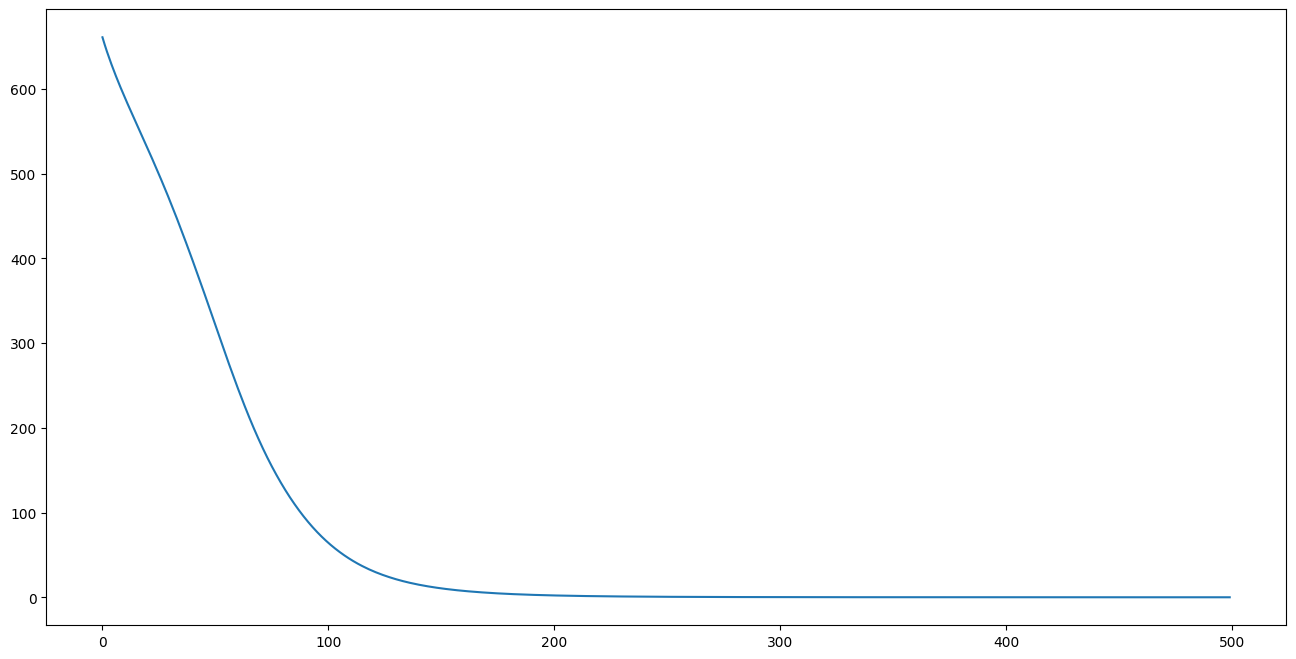

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(np.asarray(loss_list))

plt.show()

Informação sobre outras camadas lineares, como nn.Bilinear e nn.Identity, podem ser vistas na documentação: https://pytorch.org/docs/stable/nn.html#linear-layers